#Library imports

In [ ]:
!pip install yfinance

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Activation, Reshape, RepeatVector, Concatenate, BatchNormalization, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredLogarithmicError
import matplotlib.pyplot as plt
import seaborn as sns

#Data import and visualization

In [ ]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

# Get Bitcoin data
data = yf.download(tickers='BTC-USD', period = '2y', interval = '1d')

#declare figure
fig = go.Figure()

#Candlestick
fig.add_trace(go.Candlestick(x=data.index,
open=data['Open'],
high=data['High'],
low=data['Low'],
close=data['Close'], name = 'market data'))

# Add titles
fig.update_layout(
title='Bitcoin live share price evolution',
yaxis_title='Bitcoin Price (kUS Dollars)')

# X-Axes
fig.update_xaxes(
rangeslider_visible=True,
rangeselector=dict(
buttons=list([
dict(count=15, label="15m", step="minute", stepmode="backward"),
dict(count=45, label="45m", step="minute", stepmode="backward"),
dict(count=1, label="HTD", step="hour", stepmode="todate"),
dict(count=6, label="6h", step="hour", stepmode="backward"),
dict(step="all")
])
)
)


In [ ]:
data = data.reset_index()

In [ ]:
# Get Ethereum data
data_eth = yf.download(tickers='ETH-USD', period = '2y', interval = '1d')

#declare figure
fig = go.Figure()

#Candlestick
fig.add_trace(go.Candlestick(x=data.index,
open=data_eth['Open'],
high=data_eth['High'],
low=data_eth['Low'],
close=data_eth['Close'], name = 'market data'))

# Add titles
fig.update_layout(
title='Ethereum live share price evolution',
yaxis_title='Ethereum Price (US Dollars)')

# X-Axes
fig.update_xaxes(
rangeslider_visible=True,
rangeselector=dict(
buttons=list([
dict(count=15, label="15m", step="minute", stepmode="backward"),
dict(count=45, label="45m", step="minute", stepmode="backward"),
dict(count=1, label="HTD", step="hour", stepmode="todate"),
dict(count=6, label="6h", step="hour", stepmode="backward"),
dict(step="all")
])
)
)

In [ ]:
data_eth = data_eth.reset_index()

In [ ]:
# Get Ripple data
data_xrp = yf.download(tickers='XRP-USD', period = '2y', interval = '1d')

#declare figure
fig = go.Figure()

#Candlestick
fig.add_trace(go.Candlestick(x=data.index,
open=data_xrp['Open'],
high=data_xrp['High'],
low=data_xrp['Low'],
close=data_xrp['Close'], name = 'market data'))

# Add titles
fig.update_layout(
title='Ripple live share price evolution',
yaxis_title='Ripple Price (US Dollars)')

# X-Axes
fig.update_xaxes(
rangeslider_visible=True,
rangeselector=dict(
buttons=list([
dict(count=15, label="15m", step="minute", stepmode="backward"),
dict(count=45, label="45m", step="minute", stepmode="backward"),
dict(count=1, label="HTD", step="hour", stepmode="todate"),
dict(count=6, label="6h", step="hour", stepmode="backward"),
dict(step="all")
])
)
)

In [ ]:
data_xrp = data_xrp.reset_index()

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-02-24,9921.583008,9951.746094,9537.042969,9650.174805,9650.174805,45080496648
1,2020-02-25,9651.312500,9652.737305,9305.021484,9341.705078,9341.705078,42515259129
2,2020-02-26,9338.290039,9354.778320,8704.426758,8820.522461,8820.522461,50420050762
3,2020-02-27,8825.093750,8932.892578,8577.199219,8784.494141,8784.494141,45470195695
4,2020-02-28,8788.728516,8890.456055,8492.932617,8672.455078,8672.455078,44605450443


In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,731.000000,731.000000,731.000000,731.000000,731.000000,7.310000e+02
mean,31589.703567,32436.365010,30640.454413,31621.729475,31621.729475,3.966103e+10
std,19055.674907,19548.769877,18461.978143,19033.627051,19033.627051,2.087059e+10
min,5002.578125,5331.833984,4106.980957,4970.788086,4970.788086,1.225260e+10
25%,10797.034180,10967.020996,10652.977539,10820.795898,10820.795898,2.668746e+10
50%,34700.363281,36378.328125,33432.074219,35030.250000,35030.250000,3.551164e+10
75%,47790.845703,49175.048828,46685.369141,47747.423828,47747.423828,4.753424e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


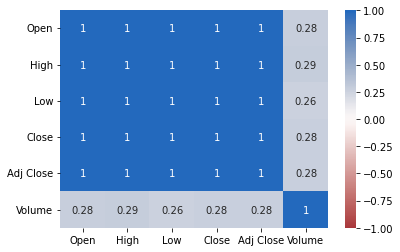

In [ ]:
sns.heatmap(data.corr(), annot = True, cmap = 'vlag_r', vmin = -1, vmax = 1)

#Processing functions

In [ ]:
"""
Method to split the dataset in the training set and test set after dropping the 
useless columns.
"""
def split_dataset(data = data, date = '2021-12-15'):
  df_train = data[data['Date']<date].copy()
  df_test = data[data['Date']>=date].copy()
  df_train = df_train.drop(['Date'], axis = 1)
  df_test = df_test.drop(['Date'], axis = 1)
  return df_train, df_test

In [ ]:
""" 
Method to normalize the dataframe according to the mean and the standard
deviation of the training set.
Returns the corresponding normalized ndarray.
"""
def normalize_data(dataset, data_train):
  data_mean = data_train.mean()
  data_std = data_train.std()
  data_train_norm = (dataset - data_mean)/data_std
  return data_train_norm.to_numpy()

In [ ]:
"""
Method to create the test set. Since we are working with historical time series
the first input to make a prediction will be made up by the last training samples.
In addition to them we have the following timesteps to be predicted.
Note that the parameters are not normalized.
"""
def build_test_set(train_set, test_set, look_back = 60):
  last_train_days = train_set.tail(look_back)
  df = last_train_days.append(test_set, ignore_index = True)
  test_inputs = normalize_data(df, train_set)
  return test_inputs

In [ ]:
"""
Method to split the input provided into windows of dimension: window_dim.
""" 
def build_windows(inputs, window_dim = 60, full_featured = False, default_feature_idx = 3):
  windows = []
  window_outputs = []
  # The loop takes a window that at each iteration slides of one position forward in the timeline.
  for window_idx in range (window_dim, inputs.shape[0]):
    windows.append(inputs[window_idx-window_dim:window_idx]) 
    # If we are testing the model with all the features
    if full_featured == True: 
      window_outputs.append(inputs[window_idx, :])
    # If we are testing a single-output model.
    else: 
      window_outputs.append(inputs[window_idx, default_feature_idx])
  windows, window_outputs = np.array(windows), np.array(window_outputs)
  return windows, window_outputs

In [ ]:
"""
Method to build windows to support multiple steps predictions.
window_dim: number of steps we have to inspect backwards to come up with a prediction.
forecast_horizon: number of predictions provided after the inspection of a window.
"""
def split_sequence(sequence, window_dim, forecast_horizon, full_featured = False, default_idx = 3):
 X, y = list(), list()
 for i in range(len(sequence)): 
   input_end = i + window_dim
   forecast_end = input_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   if full_featured == True:
      seq_x, seq_y = sequence[i:input_end], sequence[input_end:forecast_end]
   else:
      seq_x, seq_y = sequence[i:input_end], sequence[input_end:forecast_end, default_idx]
   X.append(seq_x)
   y.append(seq_y)
 return np.array(X), np.array(y)

In [ ]:
"""
Denormalization of the outputs/predictions.
"""
def denormalize(labels, predictions, data, full_featured = False, default_feature_idx = 3):
  test = labels.copy()
  pred = predictions.copy()
  data_mean = df_train.mean()
  data_std = df_train.std()
  if full_featured == False:
    test = test * data_std[default_feature_idx] + data_mean[default_feature_idx]
    pred = pred * data_std[default_feature_idx] + data_mean[default_feature_idx]
  else:
    test = test * data_std[None,:] + data_mean[None,:]
    pred = pred * data_std[None,:] + data_mean[None,:]
  return pred, test

In [ ]:
"""
Method to compute the accuracy of correctly predicted trends for the single step model.
"""
def compute_accuracy(predictions, test):
  predictions_diff = np.array([predictions[i+1] - predictions[i] for i in range(len(predictions)-1)])
  test_diff = np.array([test[i+1] - test[i] for i in range(len(test)-1)])
  predictions_diff[predictions_diff > 0] = 1
  predictions_diff[predictions_diff <= 0] = 0
  test_diff[test_diff > 0] = 1
  test_diff[test_diff <= 0] = 0
  TP = sum(np.logical_and(predictions_diff == 1, test_diff == 1))
  TN = sum(np.logical_and(predictions_diff == 0, test_diff == 0))
  FP = sum(np.logical_and(predictions_diff == 1, test_diff == 0))
  FN = sum(np.logical_and(predictions_diff == 0, test_diff == 1))
  return (TP+TN) / (TP+TN+FP+FN)

In [ ]:
"""
Computes the root mean squared error.
"""
def rmse(pred, true):
  return np.sqrt(np.mean((pred - true)**2))

"""
Computes the mean squared error.
"""
def mse(pred, true):
  return np.mean((pred - true)**2)

"""
Computes the mean absolute error.
"""
def mae(pred, true):
  return np.mean(np.absolute((pred - true)))

"""
Computes the mean forecast error.
"""
def mfe(pred, true):
  return np.mean(pred - true)

"""
Computes all the losses.
"""
def compute_metrics(pred, true):
  return [mse(pred, true), rmse(pred, true), mae(pred, true), mfe(pred, true)] 

In [ ]:
"""
Builds a baseline model which predicts for the step t+1 the value at step t.
"""
def baseline_model(input):
  output = np.array([input[i] for i in range(0,len(input)-1,1)])
  return output

In [ ]:
"""
Method to compute the accuracy of a multi step predictions.
It returns an array which size corresponds to the forecast horizon.
"""
def compute_accuracy_multistep(pred, true):
  accuracy = []
  predictions_diff = np.array([pred[:,i+1] - pred[:,i] for i in range((pred.shape[1])-1)])
  test_diff = np.array([true[:,i+1] - true[:,i] for i in range((true.shape[1])-1)])
  predictions_diff[predictions_diff > 0] = 1
  predictions_diff[predictions_diff <= 0] = 0
  test_diff[test_diff > 0] = 1
  test_diff[test_diff <= 0] = 0
  for i in range(pred.shape[1]-1):
    TP = sum(np.logical_and(predictions_diff[i,:] == 1, test_diff[i,:] == 1))
    TN = sum(np.logical_and(predictions_diff[i,:] == 0, test_diff[i,:] == 0))
    FP = sum(np.logical_and(predictions_diff[i,:] == 1, test_diff[i,:] == 0))
    FN = sum(np.logical_and(predictions_diff[i,:] == 0, test_diff[i,:] == 1))
    accuracy.append((TP+TN) / (TP+TN+FP+FN))
  return accuracy

In [ ]:
"""
Plots the single step predictions.
"""
def plot_single_step(Y_pred, Y_test):
  plt.figure(figsize=(14,5))
  plt.plot(Y_test,label='Inputs', marker='.', zorder=-10)
  plt.scatter(np.arange(len(Y_pred)), Y_pred, marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=50)
  plt.scatter(np.arange(len(Y_test)), Y_test, edgecolors='k', label='Real Bitcoin Price', c='#2ca02c', s=50)
  plt.title('Bitcoin Price Prediction using RNN-LSTM')
  plt.xlabel('Time')
  plt.ylabel('Price ($)')
  plt.legend()
  plt.show()

In [ ]:
"""
Method that plots three different windows and their respective
multi-step predictions.
"""
def plot_multi_step(look_back, forecast_horizon, X_t_multi_step, y_pred_multi_step_den, y_t_multi_step_den):
  fig, axs = plt.subplots(3,1,figsize=(14,8))
  for j,i in enumerate([0,look_back+forecast_horizon,2*(look_back+forecast_horizon)]):
    if i <= y_t_multi_step_den.shape[0]:
      axs[j].plot(np.arange(0,look_back,1),X_t_multi_step[i,:,0]*df_train.std()[0] + df_train.mean()[0],label='Inputs', marker='.', zorder=-10)
      axs[j].scatter(np.arange(look_back,look_back + forecast_horizon,1),y_pred_multi_step_den[i,:], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=50)
      axs[j].scatter(np.arange(look_back,look_back + forecast_horizon,1),y_t_multi_step_den[i,:], edgecolors='k', label='Real Bitcoin Price', c='#2ca02c', s=50)
      axs[j].legend()

#Model related functions

In [ ]:
"""
Compiles and trains a model.
Returns the loss function history.
"""
def compile_and_fit(model, X_train, Y_train, callback):
  model.compile(optimizer = 'adam', loss="mean_squared_error")
  history = model.fit(X_train, Y_train, epochs = 300, batch_size = 50, validation_split = 0.2, callbacks = callback)
  return history

In [ ]:
"""
Plots the loss function history.
"""
def plot_loss_history(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title("Training and Validation Loss")
  plt.legend()
  plt.show()

In [ ]:
"""
Computes the predictions.
Returns predictions and test values denormalized.
"""
def model_evaluation(model, X_test, Y_test):
  Y_pred = model.predict(X_test)
  Y_pred_den, Y_test_den = denormalize(Y_test, Y_pred, df_train)
  return Y_pred_den, Y_test_den

In [ ]:
"""
Plots the metrics on a histogram.
"""
def display_metrics(Y_pred, Y_test):
  perf = compute_metrics(Y_pred, Y_test)
  accuracy = compute_accuracy(Y_pred, Y_test)
  print('MSE: %1.2f' %perf[0])
  print('RMSE: %1.2f' %perf[1])  
  print('MAE: %1.2f' %perf[2])
  print('MFE: %1.2f' %perf[3])
  x = np.arange(3)
  plt.bar(x, height=perf[1:], color=['r','b','g'])
  plt.xticks(x, ['RMSE', 'MAE', 'MFE']);
  plt.xlabel('Errors')
  plt.ylabel('Price ($)')

#Data split and windows building

In [ ]:
df_train, df_test = split_dataset(data)
data_train_norm = normalize_data(df_train, df_train)

test_inputs = build_test_set(df_train, df_test, look_back=7)

X_train, Y_train = build_windows(window_dim = 7, inputs=data_train_norm)
X_test, Y_test = build_windows(window_dim = 7, inputs=test_inputs)


X_multi_step, y_multi_step = split_sequence(data_train_norm, window_dim=7, forecast_horizon=7)
X_t_multi_step, y_t_multi_step = split_sequence(test_inputs, window_dim=7, forecast_horizon=7)
X_multi_step.shape, y_multi_step.shape, X_t_multi_step.shape, y_t_multi_step.shape

((647, 7, 6), (647, 7), (65, 7, 6), (65, 7))

In [ ]:
df_train_eth, df_test_eth = split_dataset(data_eth)
data_train_norm_eth = normalize_data(df_train_eth, df_train_eth)

test_inputs_eth = build_test_set(df_train_eth, df_test_eth, look_back=7)

X_train_eth, Y_train_eth = build_windows(window_dim = 7, inputs=data_train_norm_eth)
X_test_eth, Y_test_eth = build_windows(window_dim = 7, inputs=test_inputs_eth)


X_multi_step_eth, y_multi_step_eth = split_sequence(data_train_norm_eth, window_dim=7, forecast_horizon=7)
X_t_multi_step_eth, y_t_multi_step_eth = split_sequence(test_inputs_eth, window_dim=7, forecast_horizon=7)

In [ ]:
df_train_xrp, df_test_xrp = split_dataset(data_xrp)
data_train_norm_xrp = normalize_data(df_train_xrp, df_train_xrp)

test_inputs_xrp = build_test_set(df_train_xrp, df_test_xrp, look_back=7)

X_train_xrp, Y_train_xrp = build_windows(window_dim = 7, inputs=data_train_norm_xrp)
X_test_xrp, Y_test_xrp = build_windows(window_dim = 7, inputs=test_inputs_xrp)


X_multi_step_xrp, y_multi_step_xrp = split_sequence(data_train_norm_xrp, window_dim=7, forecast_horizon=7)
X_t_multi_step_xrp, y_t_multi_step_xrp = split_sequence(test_inputs_xrp, window_dim=7, forecast_horizon=7)

#Single step models

Baseline model used as a reference.

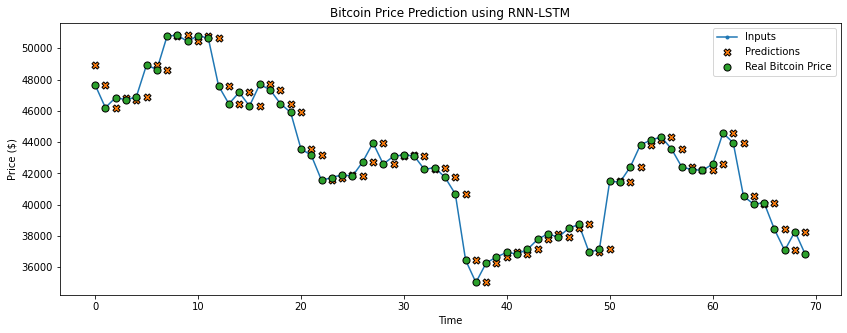

MSE: 1687339.78
RMSE: 1298.98
MAE: 912.90
MFE: 172.43
Accuracy: 0.4783


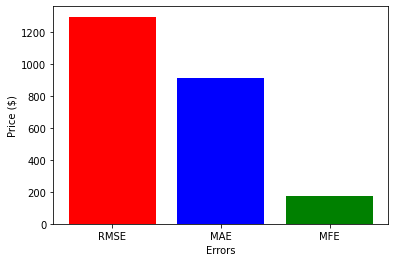

In [ ]:
baseline = baseline_model(df_test['Close'].to_numpy())
labels = df_test.to_numpy()

plot_single_step(baseline, labels[1:,3])
display_metrics(baseline, labels[1:,3])
print('Accuracy: %1.4f' %compute_accuracy(baseline, labels[1:,3]))

Pure LSTM network to carry out a single step prediction.

In [ ]:
pure_lstm_model = Sequential() 
pure_lstm_model.add(LSTM(units = 50, activation = 'tanh', return_sequences = False, 
               input_shape = (X_train.shape[1], X_train.shape[2])))
pure_lstm_model.add(Dropout(0.2))
pure_lstm_model.add(Dense(units = 1))

pure_lstm_model.summary()

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
 monitor="val_loss",
 min_delta=0.0005,
 patience=20,
 mode="min"
)

In [ ]:
history = compile_and_fit(pure_lstm_model, X_train, Y_train, early_stopping_callback)

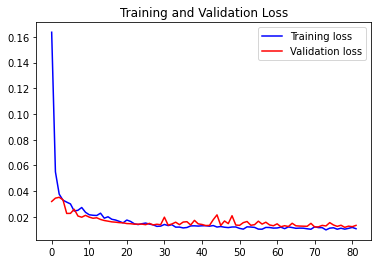

In [ ]:
plot_loss_history(history)

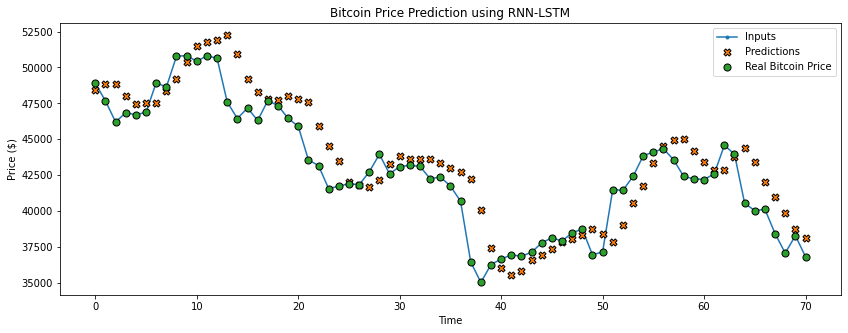

MSE: 4021205.63
RMSE: 2005.29
MAE: 1563.76
MFE: 840.67
Accuracy: 0.5143


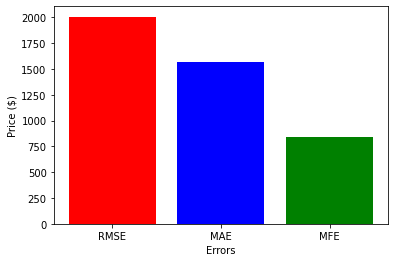

In [ ]:
Y_pred_den, Y_test_den = model_evaluation(pure_lstm_model, X_test, Y_test)
plot_single_step(Y_pred_den, Y_test_den)
display_metrics(Y_pred_den[:,0], Y_test_den)
print('Accuracy: %1.4f' %compute_accuracy(Y_pred_den[:,0], Y_test_den))

CNN-LSTM network to carry out a single step prediction.

In [ ]:
cnn_lstm_model = Sequential() 
cnn_lstm_model.add(Conv1D(filters = 32, kernel_size = 1, activation = 'tanh', padding = 'same', input_shape = (X_train.shape[1], X_train.shape[2])))
cnn_lstm_model.add(MaxPooling1D(pool_size=1, padding = 'same'))
cnn_lstm_model.add(LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_lstm_model.add(Dropout(0.2))
cnn_lstm_model.add(Dense(units = 1))

cnn_lstm_model.summary()

In [ ]:
history = compile_and_fit(cnn_lstm_model, X_train, Y_train, early_stopping_callback)

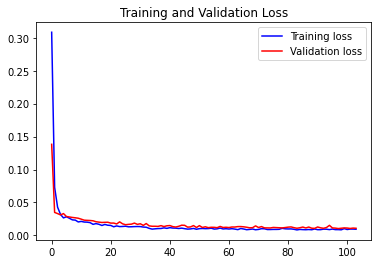

In [ ]:
plot_loss_history(history)

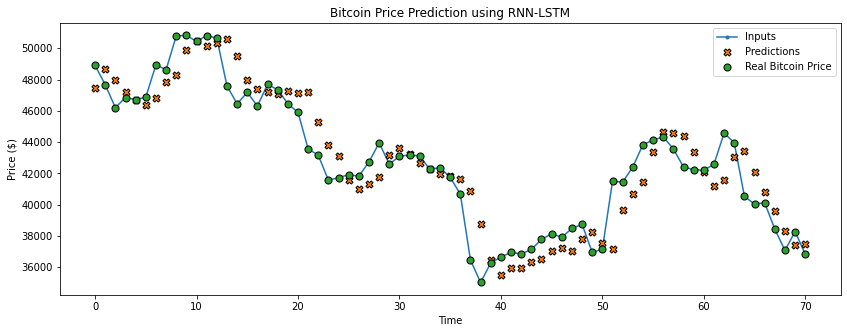

MSE: 2660621.34
RMSE: 1631.14
MAE: 1272.71
MFE: 82.38
Accuracy 0.5429


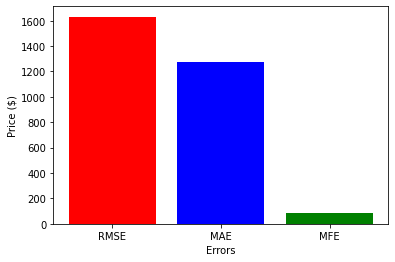

In [ ]:
Y_pred_den, Y_test_den = model_evaluation(cnn_lstm_model, X_test, Y_test)
plot_single_step(Y_pred_den, Y_test_den)
display_metrics(Y_pred_den[:,0], Y_test_den)
accuracy = compute_accuracy(Y_pred_den[:,0], Y_test_den)
print('Accuracy %1.4f' %accuracy)

Multi currency model.

In [ ]:
input_shape_1 = Input(shape=(X_train.shape[1], X_train.shape[2]))
input_shape_2 = Input(shape=(X_train.shape[1], X_train.shape[2]))
input_shape_3 = Input(shape=(X_train.shape[1], X_train.shape[2]))
crypto_1 = Conv1D(filters = 16, kernel_size = 2)(input_shape_1)
crypto_1 = MaxPooling1D(pool_size=2)(crypto_1)
crypto_1 = LSTM(50)(crypto_1)
model_1 = tf.keras.Model(inputs=input_shape_1, outputs=crypto_1)

crypto_2 = Conv1D(filters = 16, kernel_size = 2)(input_shape_2)
crypto_2 = MaxPooling1D(pool_size=2)(crypto_2)
crypto_2 = LSTM(50)(crypto_2)
model_2 = tf.keras.Model(inputs=input_shape_2, outputs=crypto_2)

crypto_3 = Conv1D(filters = 16, kernel_size = 2)(input_shape_3)
crypto_3 = MaxPooling1D(pool_size=2)(crypto_3)
crypto_3 = LSTM(50)(crypto_3)
model_3 = tf.keras.Model(inputs=input_shape_3, outputs=crypto_3)

merged = tf.keras.layers.concatenate([model_1.output, model_2.output, model_3.output], axis=1)

out = Dense(64)(merged)
out = Dropout(0.3)(out)
out = Dense(32)(out)
out = Dropout(0.2)(out)
out = Dense(1)(out)

model = tf.keras.Model(inputs=[model_1.input, model_2.input, model_3.input], outputs=out)

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = model.fit([X_train, X_train_eth, X_train_xrp], Y_train, epochs = 300, batch_size = 50, validation_split = 0.2, callbacks = early_stopping_callback)

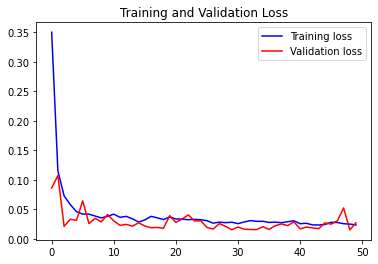

In [ ]:
plot_loss_history(history)

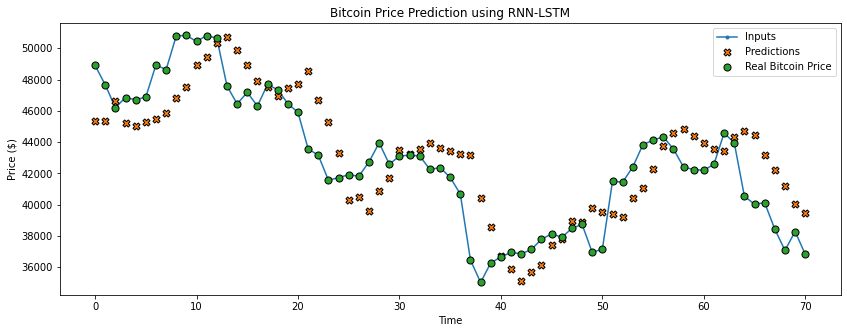

MSE: 6079972.03
RMSE: 2465.76
MAE: 2046.62
MFE: 435.45
Accuracy = 0.4857


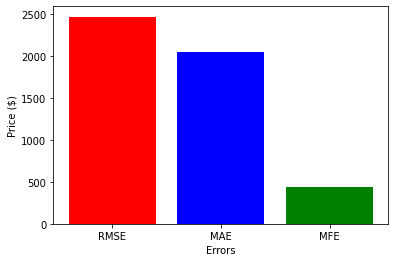

In [ ]:
Y_pred = model.predict([X_test, X_test_eth, X_test_xrp])
Y_pred_den, Y_test_den = denormalize(Y_test, Y_pred, df_train)
plot_single_step(Y_pred_den, Y_test_den)
display_metrics(Y_pred_den[:,0], Y_test_den)
accuracy = compute_accuracy(Y_pred_den[:,0], Y_test_den)
print('Accuracy = %1.4f' %accuracy)

#Multi step models

Pure LSTM network constituted by two LSTM layers and one Dense layer which carries out a multi step prediction.

In [ ]:
multi_pure_lstm_model = Sequential() 
multi_pure_lstm_model.add(LSTM(units = 50, activation = 'tanh', return_sequences = True, 
                    input_shape = (X_multi_step.shape[1], X_multi_step.shape[2])))
multi_pure_lstm_model.add(Dropout(0.1))
multi_pure_lstm_model.add(LSTM(units = 50, activation = 'tanh', return_sequences = False))
multi_pure_lstm_model.add(Dropout(0.2)) 
multi_pure_lstm_model.add(Dense(32))
multi_pure_lstm_model.add(Dropout(0.2)) 
multi_pure_lstm_model.add(Dense(y_multi_step.shape[1]))

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
 monitor="val_loss",
 min_delta=0.0005,
 patience=15,
 mode="min"
)

In [ ]:
history = compile_and_fit(multi_pure_lstm_model, X_multi_step, y_multi_step, early_stopping_callback)

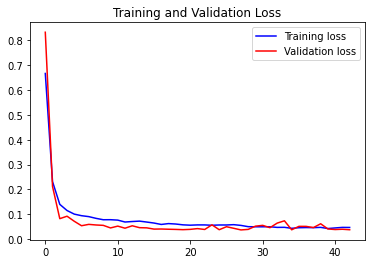

In [ ]:
plot_loss_history(history)

[0.49230769230769234, 0.5076923076923077, 0.49230769230769234, 0.5384615384615384, 0.49230769230769234, 0.5692307692307692]


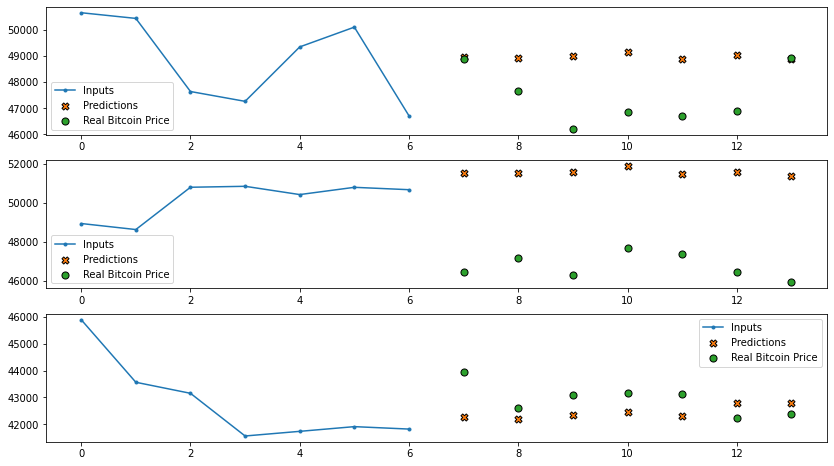

In [ ]:
Y_pred_den, Y_test_den = model_evaluation(multi_pure_lstm_model, X_t_multi_step, y_t_multi_step)
plot_multi_step(X_t_multi_step.shape[1], Y_test_den.shape[1], X_t_multi_step, Y_pred_den, Y_test_den)
accuracy = compute_accuracy_multistep(Y_pred_den, Y_test_den)
print(accuracy)

MSE: 12383847.81
RMSE: 3519.07
MAE: 2812.54
MFE: 1267.37


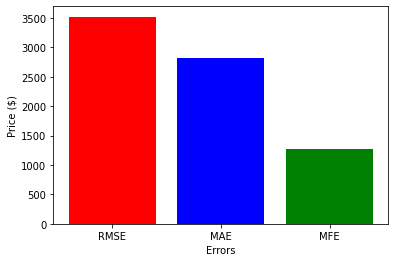

In [ ]:
display_metrics(Y_pred_den, Y_test_den)

CNN-LSTM network which carrues out a multi step prediction.

In [ ]:
multi_cnn_lstm_model = Sequential() 
multi_cnn_lstm_model.add(Conv1D(16, kernel_size=2, input_shape=(X_multi_step.shape[1], X_multi_step.shape[2])))
multi_cnn_lstm_model.add(AveragePooling1D(pool_size=2))
multi_cnn_lstm_model.add(LSTM(50, activation='tanh'))
multi_cnn_lstm_model.add(BatchNormalization())
multi_cnn_lstm_model.add(Dropout(0.2))
multi_cnn_lstm_model.add(Dense(32))
multi_cnn_lstm_model.add(BatchNormalization())
multi_cnn_lstm_model.add(Dropout(0.2))
multi_cnn_lstm_model.add(Dense(y_multi_step.shape[1]))

In [ ]:
history = compile_and_fit(multi_cnn_lstm_model, X_multi_step, y_multi_step, early_stopping_callback)

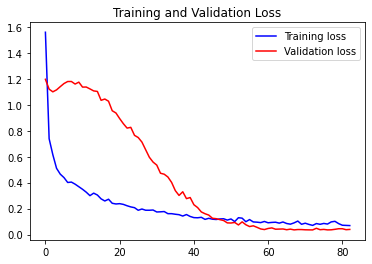

In [ ]:
plot_loss_history(history)

[0.5076923076923077, 0.47692307692307695, 0.49230769230769234, 0.5692307692307692, 0.5692307692307692, 0.49230769230769234]


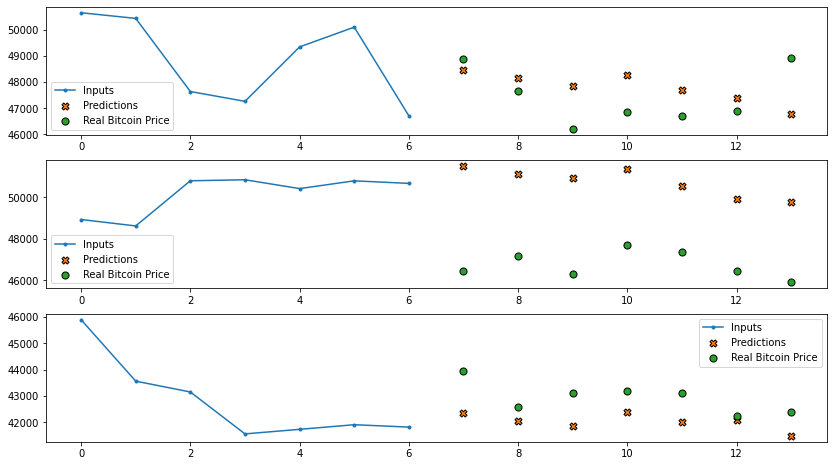

In [ ]:
Y_pred_den, Y_test_den = model_evaluation(multi_cnn_lstm_model, X_t_multi_step, y_t_multi_step)
plot_multi_step(X_t_multi_step.shape[1], Y_test_den.shape[1], X_t_multi_step, Y_pred_den, Y_test_den)
accuracy = compute_accuracy_multistep(Y_pred_den, Y_test_den)
print(accuracy)

MSE: 10553349.66
RMSE: 3248.59
MAE: 2618.59
MFE: 980.22


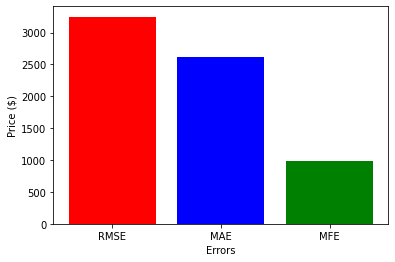

In [ ]:
display_metrics(Y_pred_den, Y_test_den)